## Load Joined Data

In [18]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# use current spark session or start one
spark = (
    SparkSession.builder
        .appName("Walrus_EDA_Joined")
        .getOrCreate()
)

# path to the already-built joined hourly panel
joined_path = "/home/wlevine/Walrus/Processed/hourly_panel"

# read joined parquet (folder)
final_df = spark.read.parquet(joined_path)

# just making sure we loaded what we think we loaded
print("=== Joined Data Schema ===")
final_df.printSchema()

print("Row count:", final_df.count())

# small preview
final_df.show(10, truncate=False)

25/11/24 12:17:25 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


=== Joined Data Schema ===
root
 |-- date: date (nullable = true)
 |-- hour: integer (nullable = true)
 |-- weekday_num: integer (nullable = true)
 |-- is_weekend: integer (nullable = true)
 |-- tod_bucket: string (nullable = true)
 |-- grid_key: string (nullable = true)
 |-- borough: string (nullable = true)
 |-- station_complex: string (nullable = true)
 |-- flow_sum: long (nullable = true)
 |-- ridership_sum: long (nullable = true)
 |-- transfers_sum: long (nullable = true)
 |-- borough_clean: string (nullable = true)
 |-- complaints_total: long (nullable = true)
 |-- complaints_noise: long (nullable = true)
 |-- complaints_heat: long (nullable = true)
 |-- complaints_other: long (nullable = true)
 |-- borough_final: string (nullable = true)

Row count: 83449
+----------+----+-----------+----------+----------+----------------+-------------+-----------------------------------+--------+-------------+-------------+-------------+----------------+----------------+---------------+--------

## Turnstile EDA

In [19]:
# basic tools for EDA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql import functions as F

In [20]:
print("Turnstile records in joined panel:", final_df.count())

final_df.select(
    "flow_sum", "ridership_sum", "transfers_sum", 
    "hour", "weekday_num", "tod_bucket", "borough"
).summary().show(truncate=False)

Turnstile records in joined panel: 83449


25/11/24 12:18:12 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------------+------------------+------------------+------------------+------------------+----------+-------------+
|summary|flow_sum         |ridership_sum     |transfers_sum     |hour              |weekday_num       |tod_bucket|borough      |
+-------+-----------------+------------------+------------------+------------------+------------------+----------+-------------+
|count  |83449            |83449             |83449             |83449             |83449             |83449     |83449        |
|mean   |274.6747115004374|262.52241488813524|13.550875384965668|11.516842622440054|3.7529509041450466|NULL      |NULL         |
|stddev |401.913912972355 |378.72406750417775|52.129319906316034|6.910796943256835 |1.9751015715659492|NULL      |NULL         |
|min    |1                |1                 |0                 |0                 |1                 |AM Peak   |Bronx        |
|25%    |29               |28                |0                 |6                 |2            

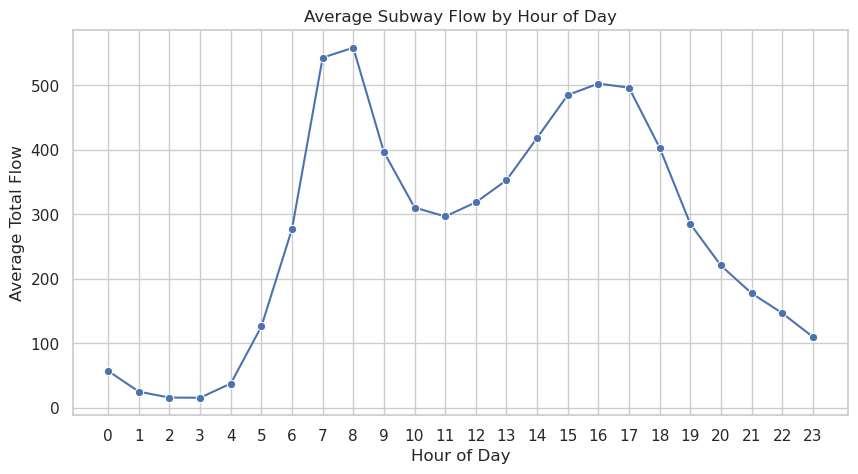

In [22]:
ts_hour = (
    final_df.groupBy("hour")
            .agg(F.avg("flow_sum").alias("avg_flow"))
            .orderBy("hour")
)

ts_hour_pd = ts_hour.toPandas()

plt.figure(figsize=(10,5))
sns.lineplot(data=ts_hour_pd, x="hour", y="avg_flow", marker="o")
plt.title("Average Subway Flow by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Total Flow")
plt.xticks(range(0,24))
plt.show()

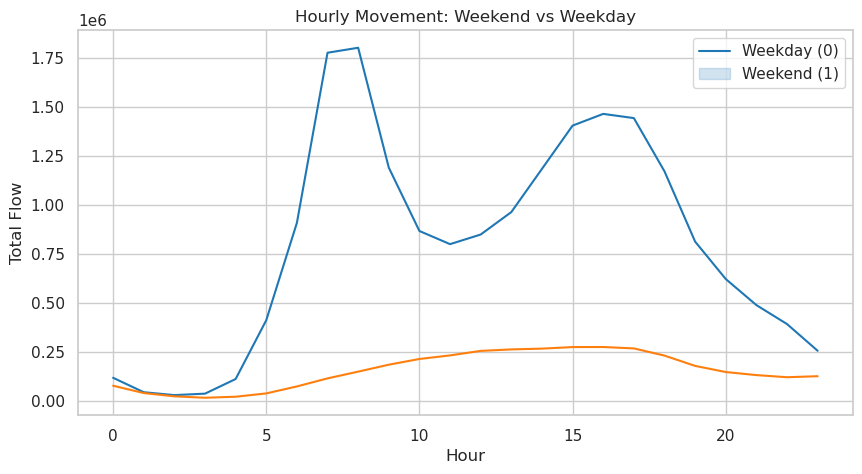

In [25]:
ts_hour_wk = (
    final_df.groupBy("is_weekend", "hour")
            .agg(F.sum("flow_sum").alias("total_flow"))
            .orderBy("is_weekend", "hour")
)

ts_hour_wk_pd = ts_hour_wk.toPandas()

plt.figure(figsize=(10,5))
sns.lineplot(
    data=ts_hour_wk_pd,
    x="hour",
    y="total_flow",
    hue="is_weekend",
    palette="tab10"
)
plt.title("Hourly Movement: Weekend vs Weekday")
plt.xlabel("Hour")
plt.ylabel("Total Flow")
plt.legend(["Weekday (0)", "Weekend (1)"])
plt.grid(True)
plt.show()

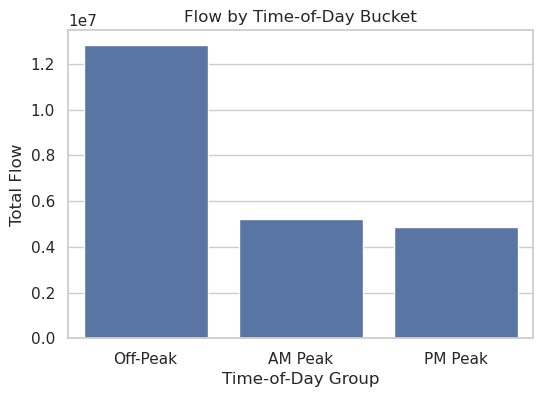

In [26]:
ts_bucket = (
    final_df.groupBy("tod_bucket")
            .agg(F.sum("flow_sum").alias("total_flow"))
            .orderBy("total_flow", ascending=False)
)

ts_bucket_pd = ts_bucket.toPandas()

plt.figure(figsize=(6,4))
sns.barplot(data=ts_bucket_pd, x="tod_bucket", y="total_flow")
plt.title("Flow by Time-of-Day Bucket")
plt.xlabel("Time-of-Day Group")
plt.ylabel("Total Flow")
plt.show()

/tmp/ipykernel_3698769/540486658.py:11: FutureWarning:                          

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


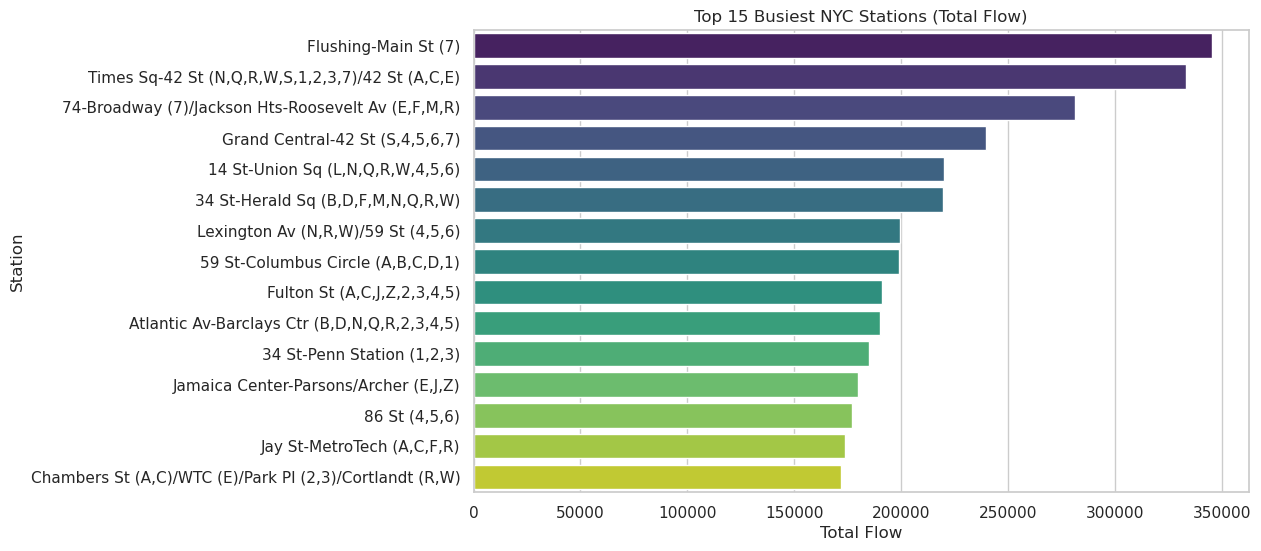

In [27]:
ts_station = (
    final_df.groupBy("station_complex")
            .agg(F.sum("flow_sum").alias("total_flow"))
            .orderBy("total_flow", ascending=False)
            .limit(15)
)

ts_station_pd = ts_station.toPandas()

plt.figure(figsize=(10,6))
sns.barplot(
    data=ts_station_pd,
    y="station_complex",
    x="total_flow",
    palette="viridis"
)
plt.title("Top 15 Busiest NYC Stations (Total Flow)")
plt.xlabel("Total Flow")
plt.ylabel("Station")
plt.show()

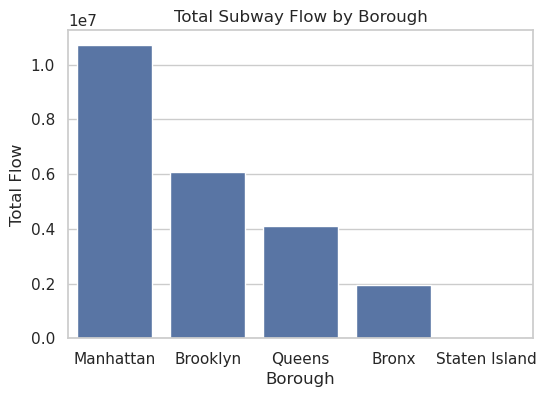

In [28]:
ts_borough = (
    final_df.groupBy("borough_final")
            .agg(F.sum("flow_sum").alias("total_flow"))
            .orderBy("total_flow", ascending=False)
)

ts_borough_pd = ts_borough.toPandas()

plt.figure(figsize=(6,4))
sns.barplot(data=ts_borough_pd, x="borough_final", y="total_flow")
plt.title("Total Subway Flow by Borough")
plt.xlabel("Borough")
plt.ylabel("Total Flow")
plt.show()

## 311 EDA SETUP

In [31]:
from pyspark.sql import functions as F

# 1. Basic renaming for convenience
sr = sr311_raw.withColumnRenamed("Complaint Type", "complaint") \
              .withColumnRenamed("Descriptor", "descriptor") \
              .withColumnRenamed("Borough", "borough_raw") \
              .withColumnRenamed("Latitude", "lat") \
              .withColumnRenamed("Longitude", "lon") \
              .withColumnRenamed("Created Date", "created_date")

# 2. Parse datetime safely (the 311 timestamp format is "MM/dd/yyyy hh:mm:ss a")
sr = sr.withColumn(
    "dt",
    F.to_timestamp("created_date", "MM/dd/yyyy hh:mm:ss a")
)

# Filter out rows without timestamps or coordinates
sr = sr.filter(F.col("dt").isNotNull()) \
       .filter(F.col("lat").isNotNull() & F.col("lon").isNotNull())

# 3. Basic time features
sr = (
    sr.withColumn("date", F.to_date("dt"))
      .withColumn("hour", F.hour("dt"))
      .withColumn("weekday_num", F.dayofweek("dt"))
      .withColumn("day_name", F.date_format("dt", "EEEE"))
      .withColumn("is_weekend", F.when(F.col("weekday_num").isin(1,7), 1).otherwise(0))
)

# 4. Time-of-day buckets
sr = sr.withColumn(
    "tod_bucket",
    F.when((F.col("hour") >= 7) & (F.col("hour") < 10), "AM Peak")
     .when((F.col("hour") >= 16) & (F.col("hour") < 19), "PM Peak")
     .otherwise("Off-Peak")
)

# 5. Clean complaint strings
sr = sr.withColumn(
    "complaint_clean",
    F.lower(F.regexp_replace("complaint", r"[^A-Za-z0-9]+", "_"))
)

# 6. Complaint category grouping (noise / heat / other)
sr = sr.withColumn(
    "complaint_group",
    F.when(F.col("complaint_clean").like("noise%"), "noise")
     .when(F.col("complaint_clean").like("heat%"), "heat_hot_water")
     .otherwise("other")
)

# 7. Borough clean
sr = sr.withColumn(
    "borough_clean",
    F.lower(F.trim(F.col("borough_raw")))
)

# 8. Rounded lat/lon grid cells (matches turnstile_final)
sr = sr.withColumn("lat_4", F.round("lat", 4)) \
       .withColumn("lon_4", F.round("lon", 4))

# 9. Build grid_key
sr = sr.withColumn(
    "grid_key",
    F.concat_ws("_", F.col("lat_4"), F.col("lon_4"))
)

# 10. Select final cleaned 311 fields
sr311_final = sr.select(
    "dt", "date", "hour", "weekday_num", "day_name",
    "is_weekend", "tod_bucket",
    "complaint", "descriptor",
    "complaint_clean", "complaint_group",
    "borough_clean", "lat", "lon", "lat_4", "lon_4", "grid_key"
)

print(">>> CLEANED 311 READY")
sr311_final.printSchema()
sr311_final.show(5, truncate=False)

>>> CLEANED 311 READY
root
 |-- dt: timestamp (nullable = true)
 |-- date: date (nullable = true)
 |-- hour: integer (nullable = true)
 |-- weekday_num: integer (nullable = true)
 |-- day_name: string (nullable = true)
 |-- is_weekend: integer (nullable = false)
 |-- tod_bucket: string (nullable = false)
 |-- complaint: string (nullable = true)
 |-- descriptor: string (nullable = true)
 |-- complaint_clean: string (nullable = true)
 |-- complaint_group: string (nullable = false)
 |-- borough_clean: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- lat_4: double (nullable = true)
 |-- lon_4: double (nullable = true)
 |-- grid_key: string (nullable = false)

+-------------------+----------+----+-----------+--------+----------+----------+--------------------------+--------------------------------+--------------------------+---------------+-------------+--------------+---------------+-------+--------+----------------+
|dt                 |d

In [32]:
from pyspark.sql import functions as F

top_complaints = (
    sr311_final
        .groupBy("complaint_clean")
        .count()
        .orderBy(F.desc("count"))
)

top_complaints.show(15, truncate=False)

+---------------------+-----+
|complaint_clean      |count|
+---------------------+-----+
|illegal_parking      |11749|
|heat_hot_water       |7589 |
|noise_residential    |5848 |
|blocked_driveway     |3876 |
|unsanitary_condition |2499 |
|noise_street_sidewalk|1704 |
|abandoned_vehicle    |1686 |
|plumbing             |1609 |
|paint_plaster        |1457 |
|noise_commercial     |1336 |
|water_system         |1293 |
|dirty_condition      |1254 |
|noise                |1237 |
|derelict_vehicles    |1145 |
|street_condition     |1137 |
+---------------------+-----+
only showing top 15 rows



In [33]:
complaint_groups = (
    sr311_final
        .groupBy("complaint_group")
        .count()
        .orderBy(F.desc("count"))
)

complaint_groups.show(truncate=False)

+---------------+-----+
|complaint_group|count|
+---------------+-----+
|other          |49232|
|noise          |11660|
|heat_hot_water |7589 |
+---------------+-----+



In [34]:
complaints_by_borough = (
    sr311_final
        .groupBy("borough_clean")
        .count()
        .orderBy(F.desc("count"))
)

complaints_by_borough.show(truncate=False)

+-------------+-----+
|borough_clean|count|
+-------------+-----+
|brooklyn     |21406|
|queens       |16502|
|manhattan    |14278|
|bronx        |13951|
|staten island|2340 |
|unspecified  |4    |
+-------------+-----+



In [35]:
hourly_complaints = (
    sr311_final
        .groupBy("hour")
        .agg(F.count("*").alias("total_complaints"))
        .orderBy("hour")
)

hourly_complaints.show(24)

+----+----------------+
|hour|total_complaints|
+----+----------------+
|   0|            2192|
|   1|            1445|
|   2|            1007|
|   3|             763|
|   4|             795|
|   5|             921|
|   6|            1431|
|   7|            2755|
|   8|            3478|
|   9|            4333|
|  10|            4112|
|  11|            4241|
|  12|            4145|
|  13|            3619|
|  14|            3781|
|  15|            3967|
|  16|            3885|
|  17|            3317|
|  18|            3203|
|  19|            2970|
|  20|            3054|
|  21|            3208|
|  22|            3068|
|  23|            2791|
+----+----------------+



In [36]:
dow_complaints = (
    sr311_final
        .groupBy("weekday_num", "day_name")
        .count()
        .orderBy("weekday_num")
)

dow_complaints.show(truncate=False)

+-----------+---------+-----+
|weekday_num|day_name |count|
+-----------+---------+-----+
|1          |Sunday   |7271 |
|2          |Monday   |17974|
|3          |Tuesday  |9264 |
|4          |Wednesday|8918 |
|5          |Thursday |8708 |
|6          |Friday   |8349 |
|7          |Saturday |7997 |
+-----------+---------+-----+



In [37]:
noise_by_hour = (
    sr311_final
        .filter(F.col("complaint_group") == "noise")
        .groupBy("hour")
        .count()
        .orderBy("hour")
)

noise_by_hour.show(24)

+----+-----+
|hour|count|
+----+-----+
|   0| 1069|
|   1|  687|
|   2|  419|
|   3|  302|
|   4|  238|
|   5|  197|
|   6|  207|
|   7|  249|
|   8|  239|
|   9|  285|
|  10|  252|
|  11|  321|
|  12|  342|
|  13|  284|
|  14|  336|
|  15|  389|
|  16|  480|
|  17|  488|
|  18|  636|
|  19|  622|
|  20|  574|
|  21|  780|
|  22| 1098|
|  23| 1166|
+----+-----+



In [39]:
grid_density = (
    sr311_final
        .groupBy("grid_key")
        .agg(
            F.count("*").alias("total_complaints"),
            F.sum(F.when(F.col("complaint_group") == "noise", 1).otherwise(0)).alias("noise"),
            F.sum(F.when(F.col("complaint_group") == "heat_hot_water", 1).otherwise(0)).alias("heat"),
        )
        .orderBy(F.desc("total_complaints"))
)

grid_density.show(20, truncate=False)

+----------------+----------------+-----+----+
|grid_key        |total_complaints|noise|heat|
+----------------+----------------+-----+----+
|40.7049_-74.0075|221             |11   |56  |
|40.722_-73.8097 |211             |2    |0   |
|40.6934_-73.9889|205             |0    |0   |
|40.6685_-73.8469|170             |170  |0   |
|40.8544_-73.8984|159             |1    |157 |
|40.6548_-73.8732|145             |0    |0   |
|40.7647_-73.9272|122             |0    |119 |
|40.7224_-73.8095|119             |4    |0   |
|40.8074_-73.9646|104             |0    |0   |
|40.8624_-73.9111|99              |95   |0   |
|40.6673_-73.9813|97              |0    |0   |
|40.8229_-73.953 |93              |93   |0   |
|40.8315_-73.9289|87              |4    |34  |
|40.8581_-73.8909|78              |0    |76  |
|40.8369_-73.9037|74              |71   |0   |
|40.7182_-73.8393|69              |0    |52  |
|40.7418_-73.9805|66              |66   |0   |
|40.8295_-73.9408|64              |0    |52  |
|40.9056_-73.

In [40]:
hour_boro = (
    sr311_final
        .groupBy("borough_clean", "hour")
        .count()
        .orderBy("borough_clean", "hour")
)

hour_boro.show(50, truncate=False)

+-------------+----+-----+
|borough_clean|hour|count|
+-------------+----+-----+
|bronx        |0   |410  |
|bronx        |1   |291  |
|bronx        |2   |248  |
|bronx        |3   |218  |
|bronx        |4   |215  |
|bronx        |5   |245  |
|bronx        |6   |395  |
|bronx        |7   |657  |
|bronx        |8   |682  |
|bronx        |9   |903  |
|bronx        |10  |886  |
|bronx        |11  |855  |
|bronx        |12  |786  |
|bronx        |13  |704  |
|bronx        |14  |743  |
|bronx        |15  |804  |
|bronx        |16  |664  |
|bronx        |17  |710  |
|bronx        |18  |649  |
|bronx        |19  |589  |
|bronx        |20  |628  |
|bronx        |21  |620  |
|bronx        |22  |551  |
|bronx        |23  |498  |
|brooklyn     |0   |696  |
|brooklyn     |1   |455  |
|brooklyn     |2   |272  |
|brooklyn     |3   |201  |
|brooklyn     |4   |209  |
|brooklyn     |5   |272  |
|brooklyn     |6   |445  |
|brooklyn     |7   |823  |
|brooklyn     |8   |1113 |
|brooklyn     |9   |1477 |
|

In [41]:
hourly_pd = hourly_complaints.toPandas()
boro_pd = complaints_by_borough.toPandas()
groups_pd = complaint_groups.toPandas()
top_pd = top_complaints.limit(15).toPandas()

## 311 EDA

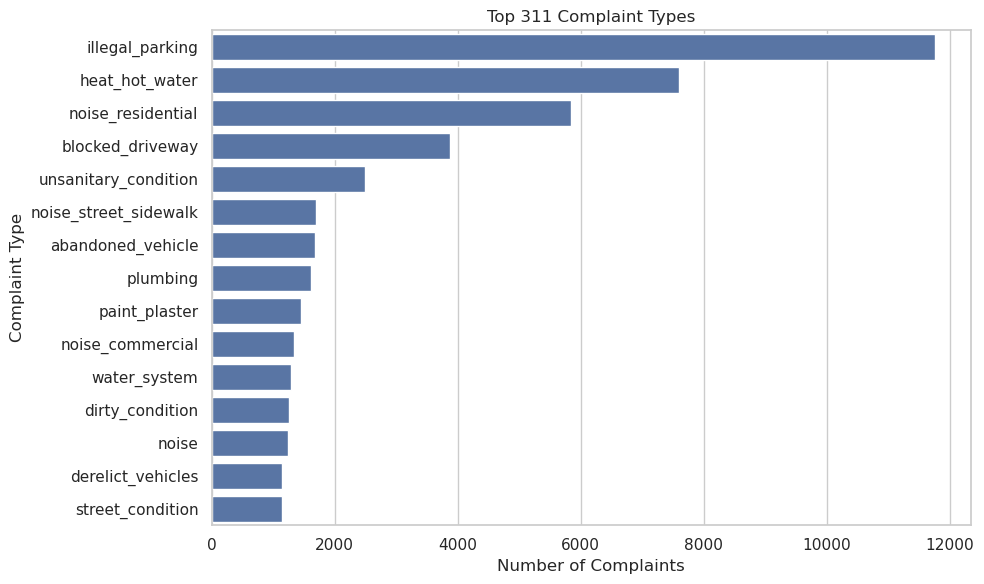

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# convert top complaints (already computed) to pandas
pdf_top = top_complaints.limit(15).toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(
    data=pdf_top,
    x="count",
    y="complaint_clean",
    orient="h"
)

plt.title("Top 311 Complaint Types")
plt.xlabel("Number of Complaints")
plt.ylabel("Complaint Type")
plt.tight_layout()
plt.show()

/tmp/ipykernel_3698769/3099892610.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


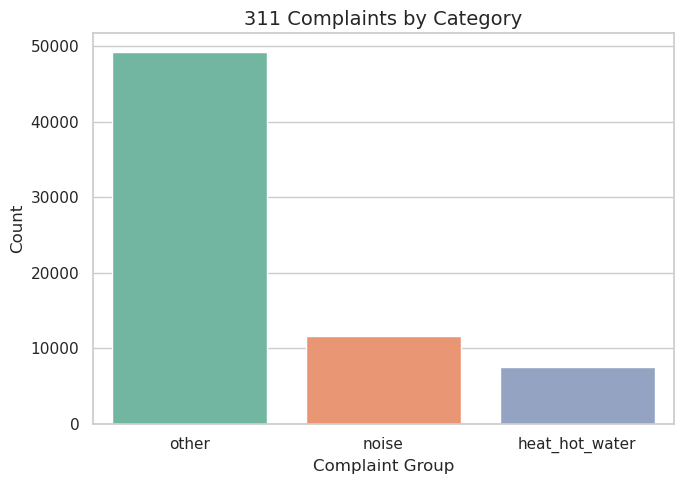

In [44]:
pdf_groups = complaint_groups.toPandas()

plt.figure(figsize=(7,5))
sns.barplot(
    data=pdf_groups,
    x="complaint_group",
    y="count",
    palette="Set2"
)

plt.title("311 Complaints by Category", fontsize=14)
plt.xlabel("Complaint Group")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

/tmp/ipykernel_3698769/1340789211.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


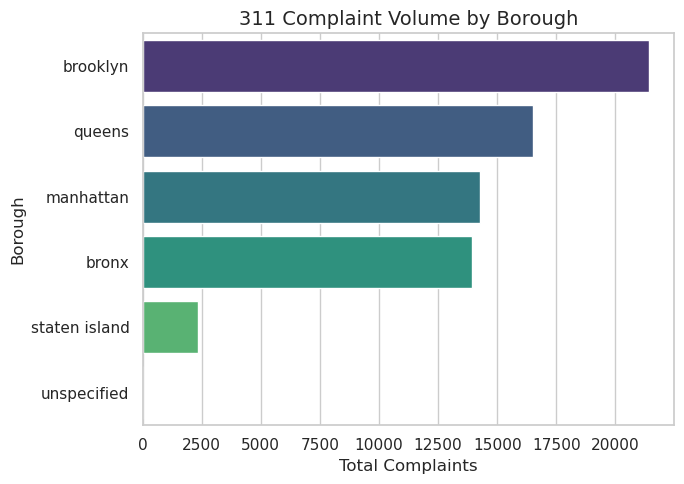

In [45]:
pdf_boro = complaints_by_borough.toPandas()

plt.figure(figsize=(7,5))
sns.barplot(
    data=pdf_boro,
    x="count",
    y="borough_clean",
    palette="viridis"
)

plt.title("311 Complaint Volume by Borough", fontsize=14)
plt.xlabel("Total Complaints")
plt.ylabel("Borough")
plt.tight_layout()
plt.show()

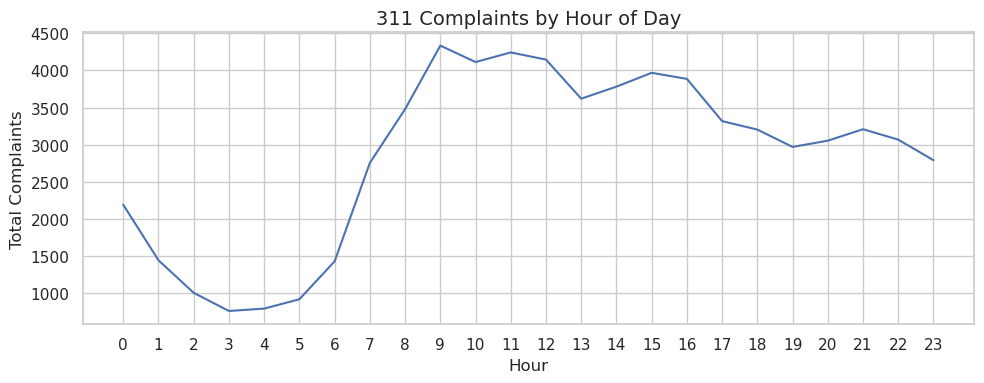

In [46]:
pdf_hour = hourly_complaints.toPandas()

plt.figure(figsize=(10,4))
sns.lineplot(
    data=pdf_hour,
    x="hour",
    y="total_complaints"
)

plt.title("311 Complaints by Hour of Day", fontsize=14)
plt.xlabel("Hour")
plt.ylabel("Total Complaints")
plt.xticks(range(0,24))
plt.tight_layout()
plt.show()

/tmp/ipykernel_3698769/1453034816.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


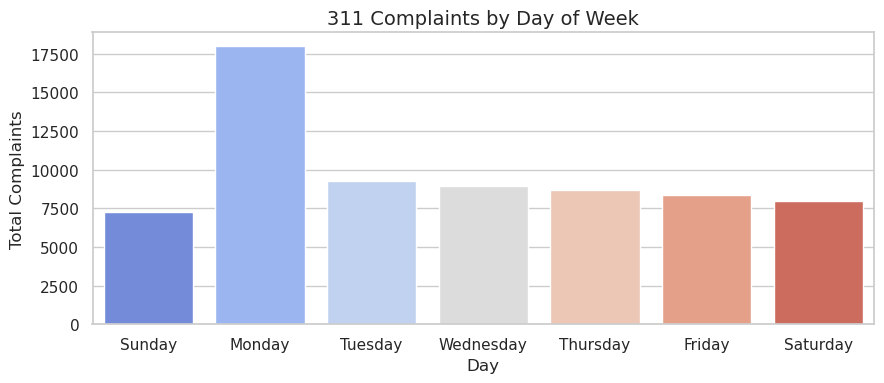

In [47]:
pdf_dow = dow_complaints.toPandas()

plt.figure(figsize=(9,4))
sns.barplot(
    data=pdf_dow,
    x="day_name",
    y="count",
    palette="coolwarm"
)

plt.title("311 Complaints by Day of Week", fontsize=14)
plt.xlabel("Day")
plt.ylabel("Total Complaints")
plt.tight_layout()
plt.show()

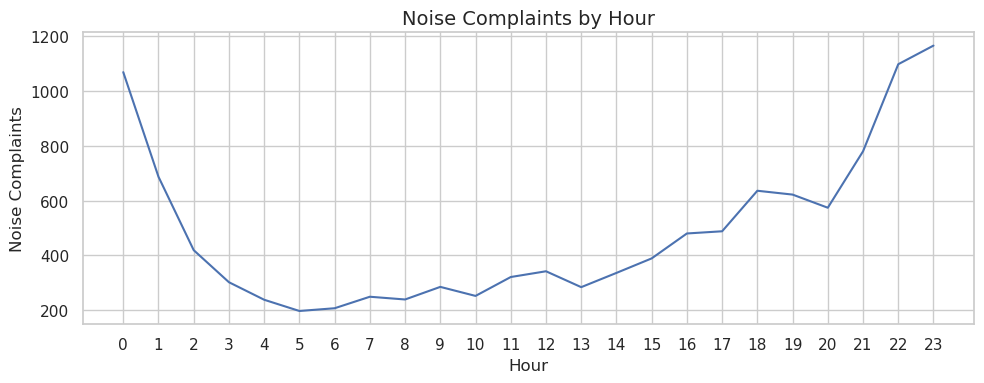

In [48]:
pdf_noise = noise_by_hour.toPandas()

plt.figure(figsize=(10,4))
sns.lineplot(
    data=pdf_noise,
    x="hour",
    y="count"
)

plt.title("Noise Complaints by Hour", fontsize=14)
plt.xlabel("Hour")
plt.ylabel("Noise Complaints")
plt.xticks(range(0,24))
plt.tight_layout()
plt.show()

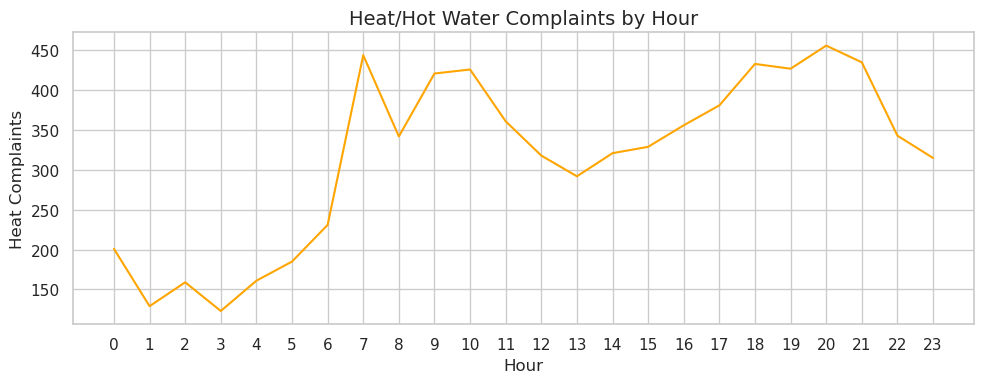

In [49]:
pdf_heat = heat_by_hour.toPandas()

plt.figure(figsize=(10,4))
sns.lineplot(
    data=pdf_heat,
    x="hour",
    y="count",
    color="orange"
)

plt.title("Heat/Hot Water Complaints by Hour", fontsize=14)
plt.xlabel("Hour")
plt.ylabel("Heat Complaints")
plt.xticks(range(0,24))
plt.tight_layout()
plt.show()

/tmp/ipykernel_3698769/1427882674.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


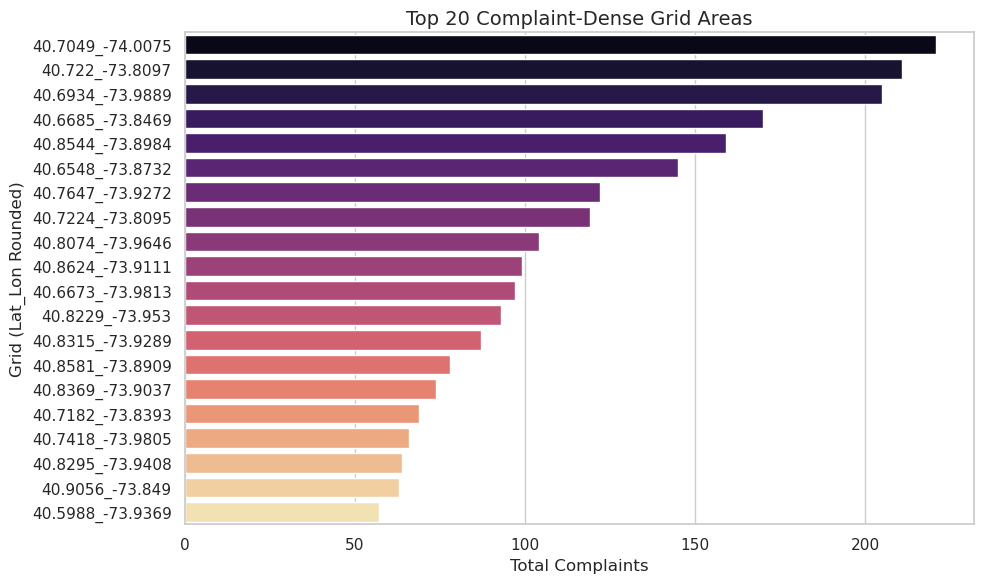

In [50]:
pdf_grid = grid_density.toPandas()

plt.figure(figsize=(10,6))
sns.barplot(
    data=pdf_grid.head(20),   # top 20 densest areas
    x="total_complaints",
    y="grid_key",
    palette="magma"
)

plt.title("Top 20 Complaint-Dense Grid Areas", fontsize=14)
plt.xlabel("Total Complaints")
plt.ylabel("Grid (Lat_Lon Rounded)")
plt.tight_layout()
plt.show()

## Joined Data EDA

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F

sns.set(style="whitegrid")

In [52]:
final_df.printSchema()
final_df.show(5, truncate=False)

print("Row count:", final_df.count())

root
 |-- date: date (nullable = true)
 |-- hour: integer (nullable = true)
 |-- weekday_num: integer (nullable = true)
 |-- is_weekend: integer (nullable = true)
 |-- tod_bucket: string (nullable = true)
 |-- grid_key: string (nullable = true)
 |-- borough: string (nullable = true)
 |-- station_complex: string (nullable = true)
 |-- flow_sum: long (nullable = true)
 |-- ridership_sum: long (nullable = true)
 |-- transfers_sum: long (nullable = true)
 |-- borough_clean: string (nullable = true)
 |-- complaints_total: long (nullable = true)
 |-- complaints_noise: long (nullable = true)
 |-- complaints_heat: long (nullable = true)
 |-- complaints_other: long (nullable = true)
 |-- borough_final: string (nullable = true)

+----------+----+-----------+----------+----------+----------------+---------+-----------------------------------+--------+-------------+-------------+-------------+----------------+----------------+---------------+----------------+-------------+
|date      |hour|weekday

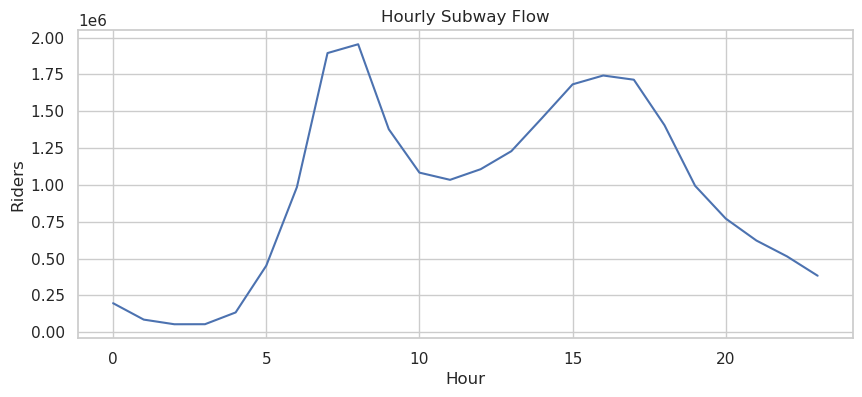

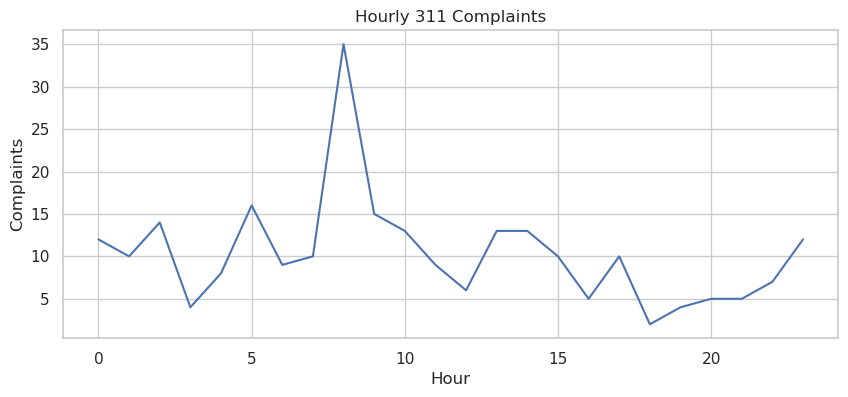

In [54]:
# sum flow + complaints by hour
hour_joined = (
    final_df.groupBy("hour")
        .agg(
            F.sum("flow_sum").alias("flow_sum"),
            F.sum("complaints_total").alias("complaints_total")
        )
        .orderBy("hour")
)

hour_pd = hour_joined.toPandas()

plt.figure(figsize=(10,4))
plt.plot(hour_pd["hour"], hour_pd["flow_sum"])
plt.title("Hourly Subway Flow")
plt.xlabel("Hour")
plt.ylabel("Riders")
plt.show()

plt.figure(figsize=(10,4))
plt.plot(hour_pd["hour"], hour_pd["complaints_total"])
plt.title("Hourly 311 Complaints")
plt.xlabel("Hour")
plt.ylabel("Complaints")
plt.show()

In [55]:
# reduce to hour + grid units
corr_df = final_df.select(
    "flow_sum",
    "complaints_total",
    "ridership_sum",
    "transfers_sum"
)

corr_pd = corr_df.toPandas()

corr_pd.corr()

,flow_sum,complaints_total,ridership_sum,transfers_sum
flow_sum,1.000000,0.017946,0.995718,0.575754
complaints_total,0.017946,1.000000,0.017895,0.007945
ridership_sum,0.995718,0.017895,1.000000,0.506335
transfers_sum,0.575754,0.007945,0.506335,1.000000


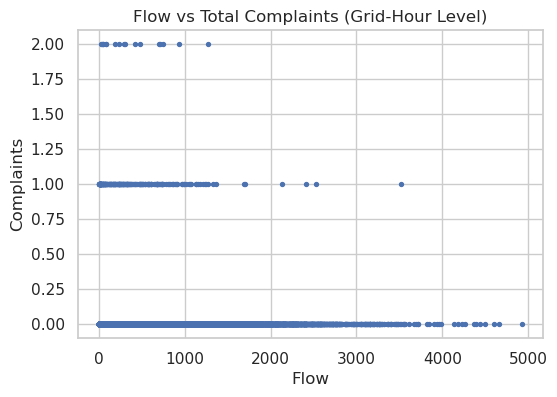

In [56]:
plt.figure(figsize=(6,4))
plt.scatter(corr_pd["flow_sum"], corr_pd["complaints_total"], s=8)
plt.title("Flow vs Total Complaints (Grid-Hour Level)")
plt.xlabel("Flow")
plt.ylabel("Complaints")
plt.show()

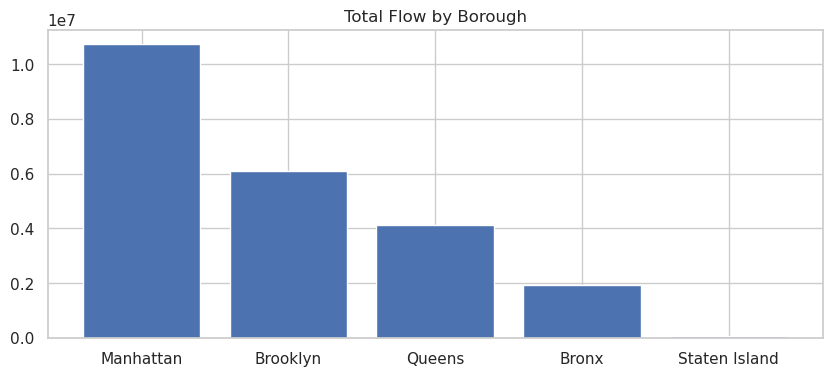

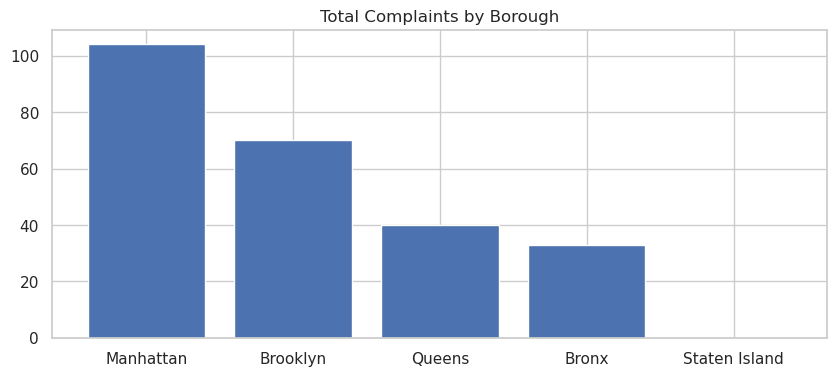

In [57]:
boro_joined = (
    final_df.groupBy("borough_final")
        .agg(
            F.sum("flow_sum").alias("flow_sum"),
            F.sum("complaints_total").alias("complaints_total")
        )
        .orderBy(F.desc("flow_sum"))
)

boro_pd = boro_joined.toPandas()

plt.figure(figsize=(10,4))
plt.bar(boro_pd["borough_final"], boro_pd["flow_sum"])
plt.title("Total Flow by Borough")
plt.show()

plt.figure(figsize=(10,4))
plt.bar(boro_pd["borough_final"], boro_pd["complaints_total"])
plt.title("Total Complaints by Borough")
plt.show()


In [58]:
top_stations = (
    final_df.groupBy("station_complex")
        .agg(
            F.sum("flow_sum").alias("flow_sum"),
            F.sum("complaints_total").alias("complaints_total")
        )
        .orderBy(F.desc("flow_sum"))
)

top_stations.show(20, truncate=False)

+-------------------------------------------------------+--------+----------------+
|station_complex                                        |flow_sum|complaints_total|
+-------------------------------------------------------+--------+----------------+
|Flushing-Main St (7)                                   |345239  |1               |
|Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)       |333289  |0               |
|74-Broadway (7)/Jackson Hts-Roosevelt Av (E,F,M,R)     |281228  |0               |
|Grand Central-42 St (S,4,5,6,7)                        |239752  |0               |
|14 St-Union Sq (L,N,Q,R,W,4,5,6)                       |219921  |0               |
|34 St-Herald Sq (B,D,F,M,N,Q,R,W)                      |219372  |0               |
|Lexington Av (N,R,W)/59 St (4,5,6)                     |199265  |0               |
|59 St-Columbus Circle (A,B,C,D,1)                      |199212  |0               |
|Fulton St (A,C,J,Z,2,3,4,5)                            |190894  |0         

In [59]:
grid_hot = (
    final_df.groupBy("grid_key")
        .agg(
            F.sum("flow_sum").alias("flow_sum"),
            F.sum("complaints_total").alias("complaints_total"),
            F.sum("complaints_noise").alias("noise"),
            F.sum("complaints_heat").alias("heat")
        )
        .orderBy(F.desc("complaints_total"))
)

grid_hot.show(20, truncate=False)

+----------------+--------+----------------+-----+----+
|grid_key        |flow_sum|complaints_total|noise|heat|
+----------------+--------+----------------+-----+----+
|40.7323_-74.0005|128250  |10              |0    |0   |
|40.7038_-73.9184|68468   |9               |0    |0   |
|40.8678_-73.8972|44595   |8               |0    |0   |
|40.7629_-73.9816|72298   |6               |0    |0   |
|40.7625_-73.986 |115716  |6               |0    |0   |
|40.7688_-73.9584|123113  |5               |1    |0   |
|40.8076_-73.9192|25048   |5               |0    |0   |
|40.8142_-73.9408|49028   |5               |0    |0   |
|40.737_-73.8772 |107949  |5               |0    |0   |
|40.6707_-73.9581|75771   |4               |0    |0   |
|40.644_-73.9797 |56471   |4               |0    |0   |
|40.7425_-73.882 |64258   |4               |0    |0   |
|40.7429_-73.9928|103298  |4               |0    |0   |
|40.8474_-73.9397|53655   |4               |0    |0   |
|40.6604_-73.9795|32810   |4               |0   

In [60]:
mismatch = (
    final_df.groupBy("hour")
        .agg(
            F.sum("flow_sum").alias("flow"),
            F.sum("complaints_total").alias("complaints")
        )
        .withColumn("ratio", F.col("complaints") / F.col("flow"))
        .orderBy(F.desc("ratio"))
)

mismatch.show()

+----+-------+----------+--------------------+
|hour|   flow|complaints|               ratio|
+----+-------+----------+--------------------+
|   2|  54091|        14|2.588230944149673...|
|   1|  85613|        10|1.168046908763855...|
|   3|  54381|         4| 7.35551019657601E-5|
|   0| 196867|        12|6.095485784819193E-5|
|   4| 134251|         8|5.958987270113444E-5|
|   5| 451515|        16|3.543625350209849E-5|
|  23| 383330|        12|3.130462004017426...|
|   8|1954320|        35|1.790904253141757...|
|  22| 514609|         7|1.360256039051007...|
|  10|1083086|        13|1.200274031794335...|
|   9|1377571|        15|1.088873096196130...|
|  13|1228622|        13|1.058095980700329...|
|   6| 984602|         9|9.140749257060213E-6|
|  14|1453148|        13|8.946094960733525E-6|
|  11|1034204|         9| 8.70234499189715E-6|
|  21| 622336|         5|8.034245166598108E-6|
|  20| 771107|         5|6.484184425767111E-6|
|  15|1682190|        10|5.944631700343005E-6|
|  17|1713669